Install prerequisites and import appropriate functions

In [27]:
%pip install pandas matplotlib scikit-learn seaborn ipympl
import pandas as pd
%matplotlib inline
#%matplotlib widget
#%matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from itertools import combinations


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Read input CSV from the folder and print it to confirm successful read

In [28]:
df_pm = pd.read_csv('22-3-2023  -  14-54.csv',delimiter=',',header='infer')
df_pm

,DateTime,Fidas 200 PM2.5,SPS30 PM2.5,SEN55 PM2.5,HPMA115 PM2.5,NextPM PM2.5,SDS011 PM2.5
0,2023-3-22 14:54:51,0,5.26,3.3,7,0.0,2.1
1,2023-3-22 14:54:57,0,4.76,3.6,7,0.0,2.0
2,2023-3-22 14:55:2,0,4.26,3.4,3,0.0,2.2
3,2023-3-22 14:55:8,0,3.81,3.4,2,10.1,2.3
4,2023-3-22 14:55:14,0,3.37,3.2,2,5.8,2.3
...,...,...,...,...,...,...,...
90055,2023-3-28 9:18:3,0,1.96,2.3,2,2.6,1.9
90056,2023-3-28 9:18:9,0,1.87,2.2,3,2.3,1.8
90057,2023-3-28 9:18:14,0,1.80,2.0,3,1.9,1.7
90058,2023-3-28 9:18:20,0,1.68,2.0,3,2.4,1.6


Define deployed sensors, drop non deployed sensors, convert first column to pandas datetime remove any erroneous values

In [29]:
# define the array of deployed sensors
deployed_sensors = ['SPS30 PM2.5', 'SEN55 PM2.5', 'HPMA115 PM2.5', 'NextPM PM2.5', 'SDS011 PM2.5']

# loop over all columns in the dataframe and drop any that are not in the columns_to_keep array, except for 'DateTime'
for col in df_pm.columns:
    if col not in deployed_sensors and col != 'DateTime':
        df_pm = df_pm.drop(col, axis=1)
df_pm['DateTime'] = pd.to_datetime(df_pm.DateTime)

# filter the dataframe to exclude rows with negative values in deployed_sensors columns
df_pm = df_pm.loc[~(df_pm[deployed_sensors] < 0).any(axis=1)]

df_pm

,DateTime,SPS30 PM2.5,SEN55 PM2.5,HPMA115 PM2.5,NextPM PM2.5,SDS011 PM2.5
0,2023-03-22 14:54:51,5.26,3.3,7,0.0,2.1
1,2023-03-22 14:54:57,4.76,3.6,7,0.0,2.0
2,2023-03-22 14:55:02,4.26,3.4,3,0.0,2.2
3,2023-03-22 14:55:08,3.81,3.4,2,10.1,2.3
4,2023-03-22 14:55:14,3.37,3.2,2,5.8,2.3
...,...,...,...,...,...,...
90055,2023-03-28 09:18:03,1.96,2.3,2,2.6,1.9
90056,2023-03-28 09:18:09,1.87,2.2,3,2.3,1.8
90057,2023-03-28 09:18:14,1.80,2.0,3,1.9,1.7
90058,2023-03-28 09:18:20,1.68,2.0,3,2.4,1.6


Plot initial graph

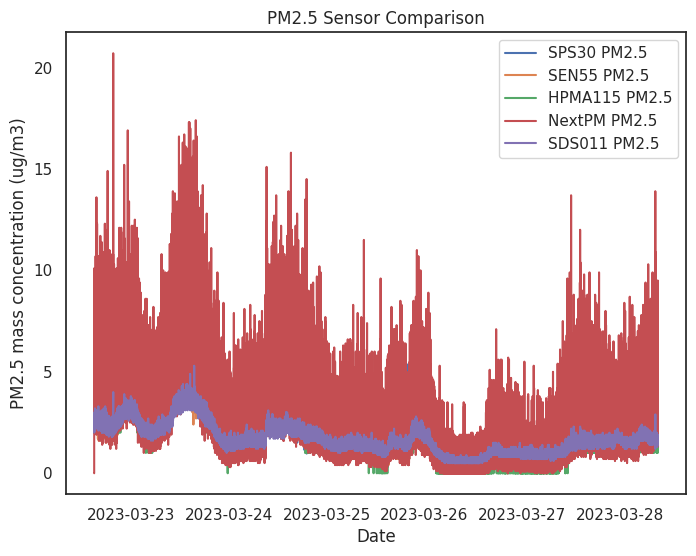

In [30]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Plot every pair of sensors against each other

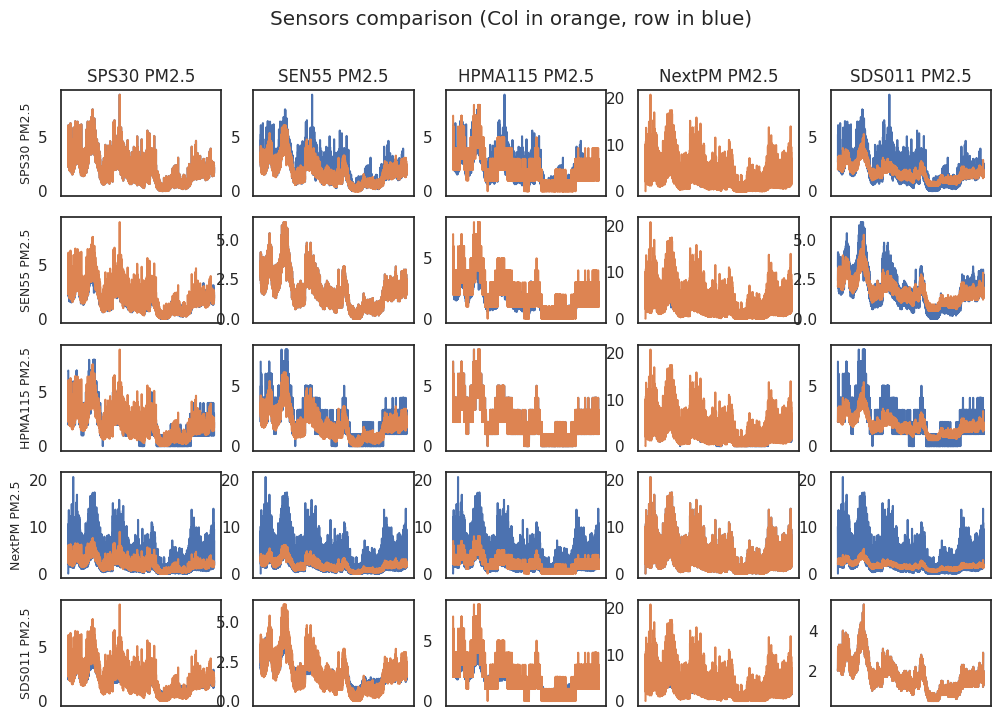

In [31]:

# create a figure object with subplots
fig, axs = plt.subplots(len(deployed_sensors), len(deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(deployed_sensors)):
    for j in range(len(deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

Plot correlation matrix

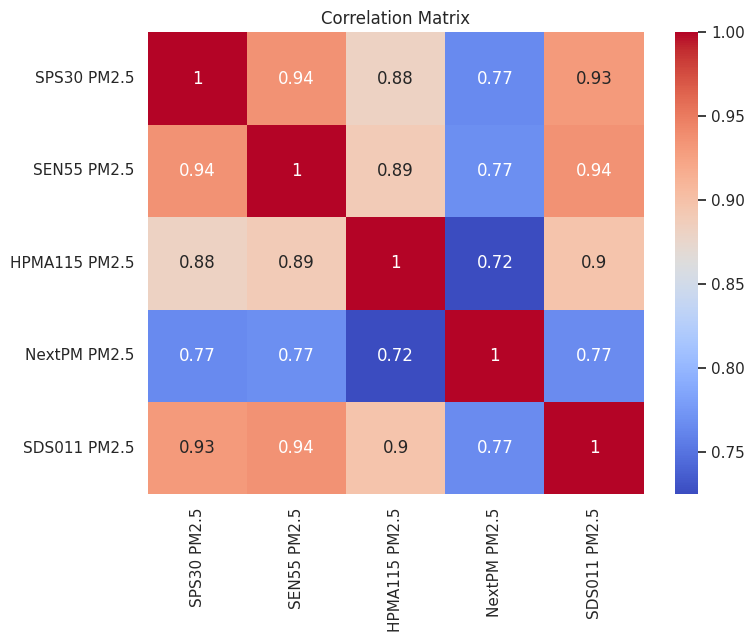

In [32]:
# create a correlation matrix for the selected columns
corr = df_pm[deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Calculate r squared between all sensors


In [33]:
# create an empty list to store the R-squared values
r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5' and 'SEN55 PM2.5': 0.8720793949949887
R-squared between 'SEN55 PM2.5' and 'SDS011 PM2.5': 0.7988790762829441
R-squared between 'SPS30 PM2.5' and 'SDS011 PM2.5': 0.7579165993505732
R-squared between 'SPS30 PM2.5' and 'HPMA115 PM2.5': 0.6638302072892652
R-squared between 'HPMA115 PM2.5' and 'SDS011 PM2.5': 0.6074200121402129
R-squared between 'SEN55 PM2.5' and 'HPMA115 PM2.5': 0.6030961527991918
R-squared between 'NextPM PM2.5' and 'SDS011 PM2.5': 0.21358394632268884
R-squared between 'HPMA115 PM2.5' and 'NextPM PM2.5': -0.5150583789147889
R-squared between 'SPS30 PM2.5' and 'NextPM PM2.5': -1.1884854091777108
R-squared between 'SEN55 PM2.5' and 'NextPM PM2.5': -1.6529222465588758


Perform data smoothing

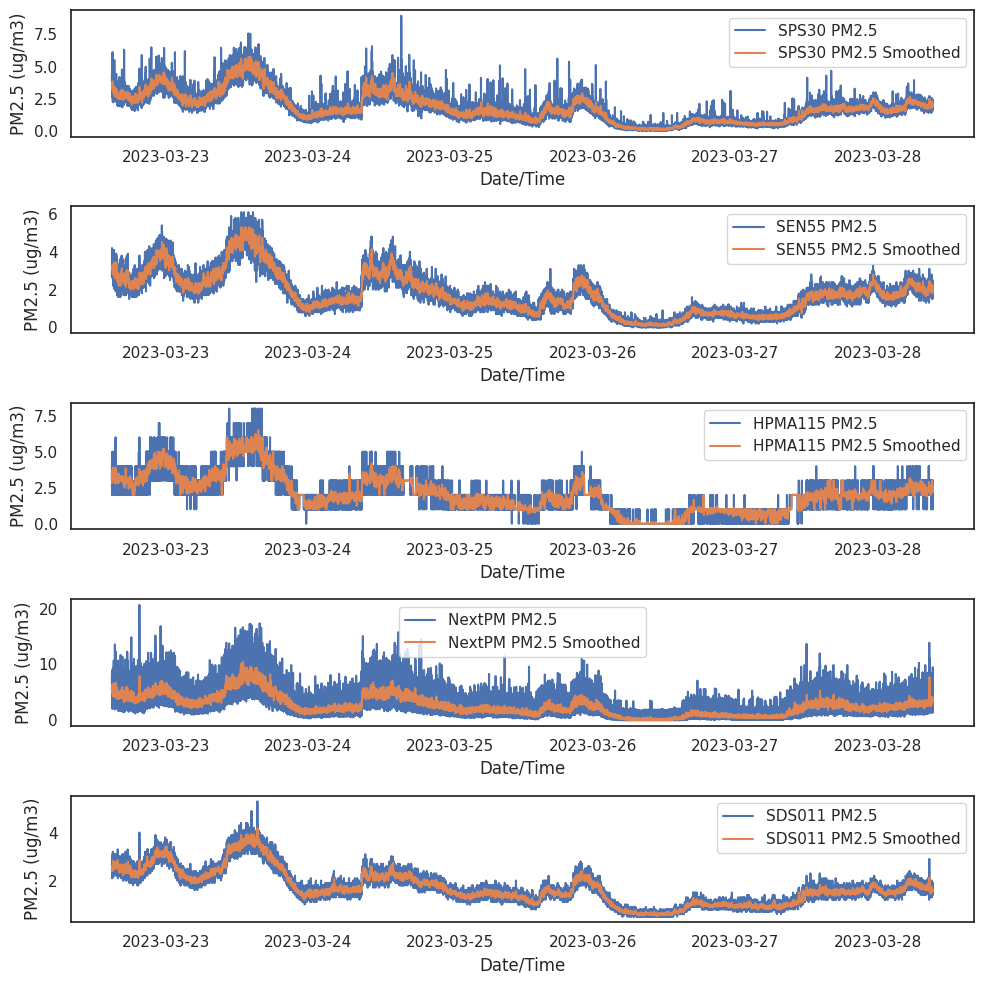

In [34]:
numtoaverage = 30

# loop through each column and perform a 30 point rolling average
for col in deployed_sensors:
    df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()

# drop the first 30 rows to avoid NaN values
df_pm = df_pm.iloc[numtoaverage:]

# plot the original and smoothed values for each column
fig, axes = plt.subplots(nrows=len(deployed_sensors), ncols=1, figsize=(10,10))
for i, col in enumerate(deployed_sensors):
    ax = axes[i]
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)
    ax.plot(df_pm['DateTime'], df_pm[f"{col} Smoothed"], label=f"{col} Smoothed")
    ax.set_xlabel('Date/Time')
    ax.set_ylabel('PM2.5 (ug/m3)')
    ax.legend()
plt.tight_layout()
plt.show()






Evaluate correlation for each smoothed element

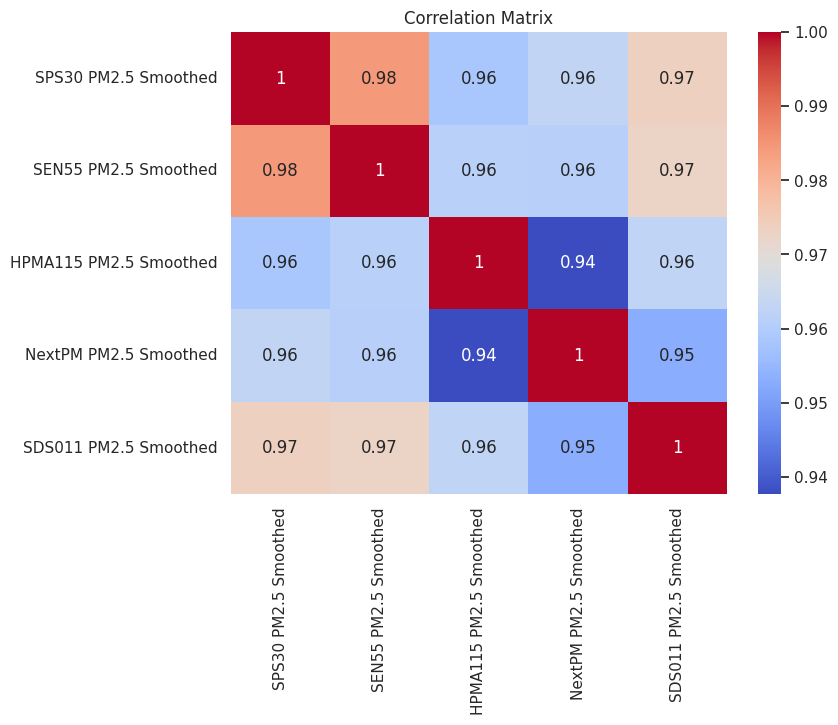

In [35]:
smoothed_deployed_sensors = [elem + " Smoothed" for elem in deployed_sensors]


# create a correlation matrix for the selected columns
corr2 = df_pm[smoothed_deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Evaluate R Squared for smoothed data

In [36]:
# create an empty list to store the R-squared values
smoothed_r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(smoothed_deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    smoothed_r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
smoothed_r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in smoothed_r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5 Smoothed' and 'SEN55 PM2.5 Smoothed': 0.9633631977453548
R-squared between 'SPS30 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': 0.8519426587198142
R-squared between 'SEN55 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': 0.8491880824692717
R-squared between 'SPS30 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': 0.8163287366309108
R-squared between 'SEN55 PM2.5 Smoothed' and 'HPMA115 PM2.5 Smoothed': 0.7955462130592743
R-squared between 'HPMA115 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': 0.6877997124473973
R-squared between 'HPMA115 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': 0.43380372592949556
R-squared between 'NextPM PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': 0.3250941962021844
R-squared between 'SPS30 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': 0.010356152075369884
R-squared between 'SEN55 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -0.29200614027945204


Plot smoothed data against each other

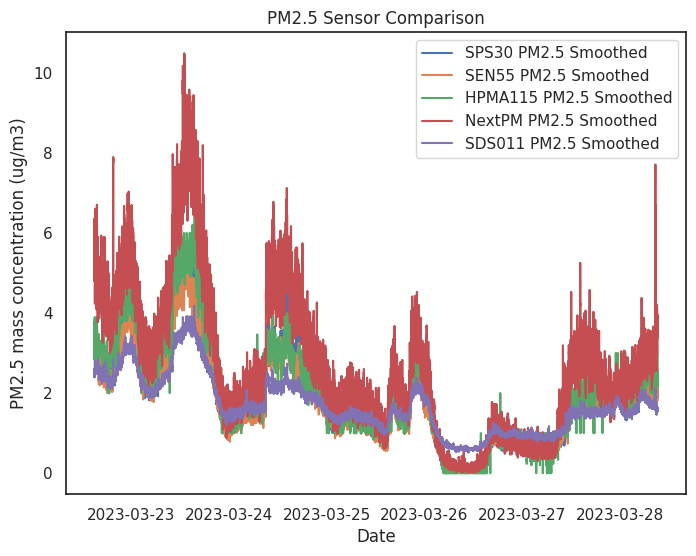

In [37]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in smoothed_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Run mass plotting again with smoothed data

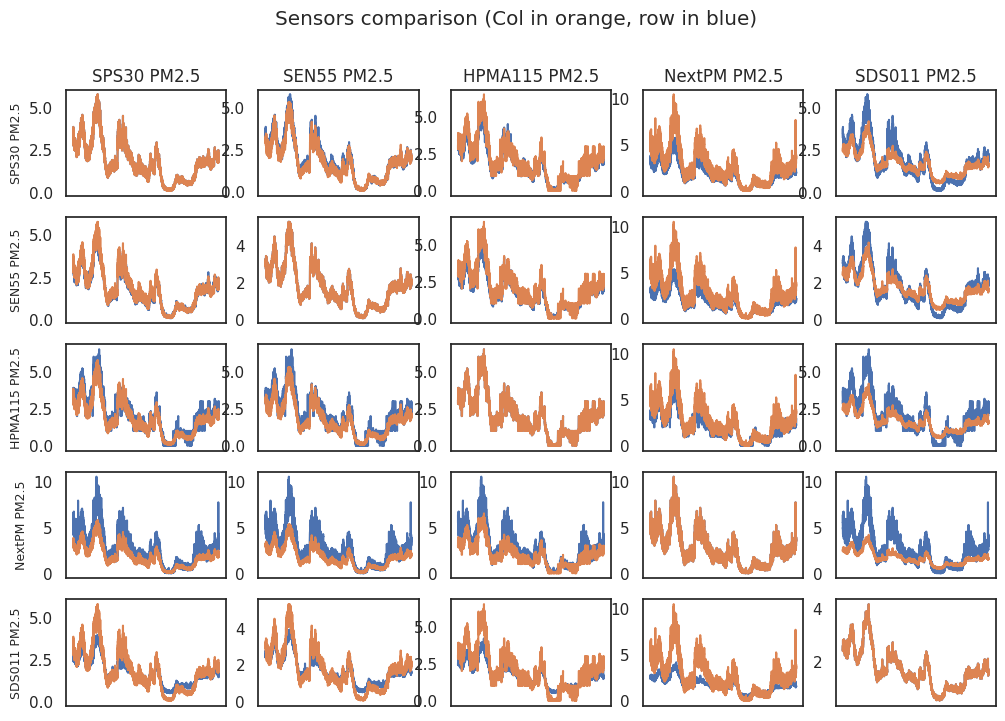

In [38]:
# create a figure object with subplots
fig, axs = plt.subplots(len(smoothed_deployed_sensors), len(smoothed_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(smoothed_deployed_sensors)):
    for j in range(len(smoothed_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()


Experiment with new denoising algos

KeyError: 'Fidas 200 PM2.5'

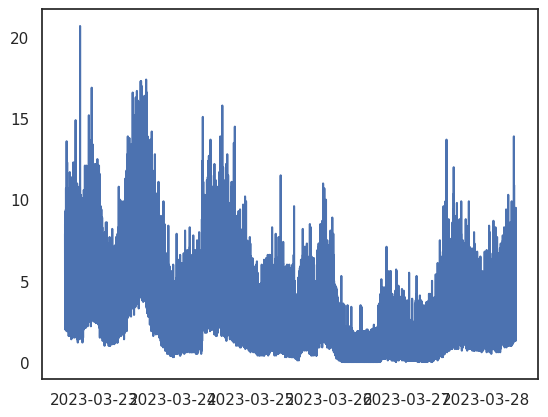

In [39]:
sensor_to_eval = 'NextPM PM2.5'

# extract the input features and target variable
X = df_pm[['DateTime']]   # input features
y = df_pm[sensor_to_eval]  # target variable

# create an instance of the KNN regressor
knn = KNeighborsRegressor(n_neighbors=80)

# fit the model to the data
knn.fit(X, y)

# make predictions on the input features
y_pred = knn.predict(X)

# plot the original data and the predicted data on the same axis
plt.plot(df_pm['DateTime'], df_pm[sensor_to_eval], label='Actual')
plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas')
plt.plot(df_pm['DateTime'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('KNN Regression')
plt.legend()
plt.show()